## Twitter US Airline Sentiment

### Description
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### Objective
This analysis predicts if the sentiment expressed by a Twitter post on the Airline is either negative, positive or neutral

#### Data Summary

In [2]:
# Import the necessary libraries, load dataset, print shape of data, data description.

In [1]:
!pip install contractions

     |████████████████████████████████| 245kB 7.1MB/s 
     |████████████████████████████████| 317kB 6.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81696 sha256=5b1dc596f3478687cfd8a7dfe73dc75dce0b672768a30c5b1fb11a067c2c94a4
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [37]:
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
# Mount Google Drive to Collaboratory 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
# Loading data into pandas dataframe
tweets_df = pd.read_csv("/content/gdrive/MyDrive/Colab_Notebooks/Tweets.csv")

##### Data Columns

In [40]:
# Understand of data-columns: drop non-relevant columns, print shape and print first 5 rows

In [41]:
# Print the dimensions of the dataset
tweets_df.shape   

(14640, 15)

In [42]:
# Print the first 5 rows of the dataframe
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [43]:
# print information on dataset
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [44]:
# keep the 'text' and 'airline_sentiment' columns.

tweets = tweets_df.loc[:, ['airline_sentiment', 'text']]
tweets.shape # shape after dropping of irrelevant columns

(14640, 2)

In [45]:
# Display full dataframe information (Non-turncated Text column.)

pd.set_option('display.max_colwidth', 0) 
tweets.head()      

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [46]:
# check for null values within the data

tweets.isnull().sum(axis=0)

airline_sentiment    0
text                 0
dtype: int64

In [47]:
# check the unique values in the label column
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [48]:
#repalcing the categorical values of 'airline_sentiment' to numeric values
#tweets['airline_sentiment'].replace(('neutral', 'positive', 'negative'), (0, 1, 2), inplace=True)
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [32]:
# extract the label variable from dataset and convert into categorical datatype

#label = tweets['airline_sentiment']
#label = tweets.astype('category')
#print(label)

      airline_sentiment                                                                                                   text
0      neutral           virginamerica dhepburn say                                                                           
1      positive          virginamerica plus add commercials experience tacky                                                  
2      neutral           virginamerica not today must mean need take another trip                                             
3      negative          virginamerica really aggressive blast obnoxious entertainment guests face little recourse            
4      negative          virginamerica really big bad thing                                                                   
...         ...                                         ...                                                                   
14635  positive          americanair thank get different flight chicago                                        

In [53]:
label = tweets_df.loc[:, ['airline_sentiment']]
label.shape # shape after dropping of irrelevant columns

(14640, 1)

In [54]:
#label = tweets.astype('category')
#print(label)

#### Data Pre-processing:

- Html tags removal.
- Replace contractions in string
- Remove the numbers.
- Removal of Special Characters and Punctuations
- Tokenization
- Conversion to lowercase
- Lemmatize or stemming
- Join the words in the list to convert back to text string in the dataframe. (So that each row contains the data in text format
- Print first 5 rows of data after pre-processing

In [55]:
# Hmtl tags removal

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

tweets['text'] = tweets['text'].apply(lambda x: strip_html(x))
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [56]:
# Replace contractions in string

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

tweets['text'] = tweets['text'].apply(lambda x: replace_contractions(x))
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [57]:
# Remove the numbers

def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

tweets['text'] = tweets['text'].apply(lambda x: remove_numbers(x))
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [58]:
# Tokenize the dataset
tweets['text'] = tweets.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 

# view the tokenized data
tweets.head() 

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [59]:
# Create the stopword lists

stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist)) 

In [60]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

tweets['text'] = tweets.apply(lambda row: normalize(row['text']), axis=1)

# Print first 5 rows of data after pre-processing
tweets.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica not today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


#### Vectorization

In [23]:
# Vectorization (Convert text data to numbers).

In [61]:
# Use Count Vectorizer to convert text data to numbers and extract features.
from sklearn.feature_extraction.text import CountVectorizer

# Keep only 1000 features to manage processing time.
vectorizer_cv = CountVectorizer(max_features=1000)
tweets_features_cv = vectorizer_cv.fit_transform(tweets['text'])

 # Convert the features into array.
tweets_features_cv = tweets_features_cv.toarray()  

tweets_features_cv.shape

(14640, 1000)

In [62]:
# Use TfidfVectorizer to convert text data to numbers and extract features.

from sklearn.feature_extraction.text import TfidfVectorizer

# Keep only 1000 features to manage processing time.
vectorizer_tf = TfidfVectorizer(max_features=1000)
tweets_features_tf = vectorizer_tf.fit_transform(tweets['text'])

 # Convert the features into array.
tweets_features_tf = tweets_features_tf.toarray()

tweets_features_tf.shape

(14640, 1000)

#### Modelling and Evaluation

###### Fit and Evaluate model using Count Vectorizer

In [63]:
# Split data with the ratio 70:30 into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets_features_cv, label, test_size=0.3, random_state=42)

In [64]:
#print(X_train)
#print(y_train)
#print(X_test)
print(y_test)

      airline_sentiment
4794   positive        
10480  negative        
8067   negative        
8880   neutral         
8292   negative        
...         ...        
12156  positive        
6518   neutral         
2245   negative        
4165   negative        
11671  negative        

[4392 rows x 1 columns]


In [65]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [66]:
# build a random forest model to classify the sentiments
rf_cv = RandomForestClassifier(n_estimators=10 ,n_jobs=4)

In [67]:
# Fit the model on the training dataset
rf_cv = rf_cv.fit(X_train, y_train)

print(rf_cv)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [68]:
# Calculate the cross validation score
print(np.mean(cross_val_score(rf_cv, tweets_features_cv, label, cv=10)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

0.7096994535519127


In [69]:
# Predict the results from the trained model on the test data

y_pred_cv = rf_cv.predict(X_test)

[[2473  251   90]
 [ 376  444   64]
 [ 162  106  426]]


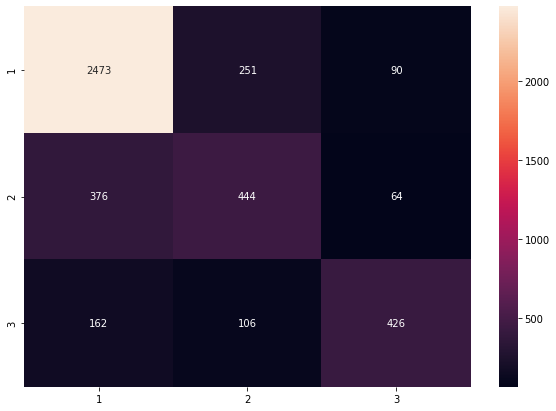

In [78]:
# Plot Confusion matrix for the actual and predicted classes for model built using Count Vectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred_cv)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

###### Fit and Evaluate model using Tf-Idf Vectorizer

In [71]:
# Split data with the ratio 70:30 into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets_features_tf, label, test_size=0.3, random_state=42)

In [72]:
# build a random forest model to classify the sentiments
rf_tf = RandomForestClassifier(n_estimators=10, n_jobs=4)

rf_tf = rf_tf.fit(X_train, y_train)

print(rf_tf)

print(np.mean(cross_val_score(rf_tf, tweets_features_tf, label, cv=10)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

0.7128415300546449


In [75]:
# Predict the results from the trained model on the test data
y_pred_tf = rf_tf.predict(X_test)

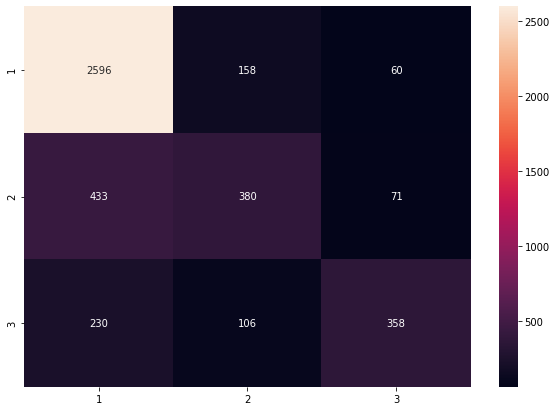

In [79]:
# Plot Confusion matrix for the actual and predicted classes for model built using Td-Ifd Vectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred_tf)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

#### Conclusion
 
 - Different pre-processing tools were applied on the 'text' column to make the dataset for the purpose of classifying the sentiments in the tweets as positive, negative and neutral
 - These tools helped to remove html tags from the raw texts, replace contractions like 'haven't' with 'have not', remove numbers, special characters like @ and punctations, converted the text to lower cases, tokenised the texts by breaking sentences into individuals words and also lematize by translating texts into their root words
 - Two types of vectorization were applied to the text column to convert the texts to numbers that can be fed into the model and also extract features from the output which are then converted to arrays for use in the modelling process. The two vectorizers are the Count and Tf-Idf Vectorizers
 - Random forest classifier was used to build the model that was used in the classification
 - Model Fitting and evaluation done using Tf-Idf Vectorizer shows a higher Cross Validation Score than that of Count Vectorizer
 - The model performed good in perspective of how the text classification models perform using the above techniques
 - The accuracy of the model can be improved by increasing the chunk of the dataset used for the model building. Only 1000 max_features were extracted from the data out of the 14640 entries representing less than 10% of dataset.)
 - Using different variations of Pre-processing techniques and model algroithms can also improve the model accuracy.